## Installing Required Python Packages

Note: run the following cell once. 

In [1]:
# !pip install -r requirements.txt

## Importing essential Python Packages

In [1]:
import os, sys

import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import scipy.linalg as sla
import pandas as pd
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import optimize
from scipy.optimize import minimize
from astropy.io import fits
from astropy import wcs
from matplotlib import cm
import pickle
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

%matplotlib notebook

`sbfTools` hold all the auxiliary functions we use in this notebook.
Make sure that `sbfTools.py` is in located in the same folder as this notebook.

In [2]:
# make sure 
from sbfTools import *

In [3]:
#https://math.stackexchange.com/questions/1114879/detect-if-two-ellipses-intersect

## Object Initialization

In [4]:
## This is the folder that holds recent observations by wfc3 on HST in a SNAP program

inFolder = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/'
configFolder = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/notebooks/config/'


In [5]:
obj = SBFobject("u03396", inFolder=inFolder, config=configFolder)

In [6]:
s = obj.slider_back_sex()

widgets.HBox(s)

Back Median: 2363.80
Back Mean: 2359.58
Back Stdev: 82.51
fig. name:  Outputs_u03396/u03396_beb89749de93/u03396_initial_back.png


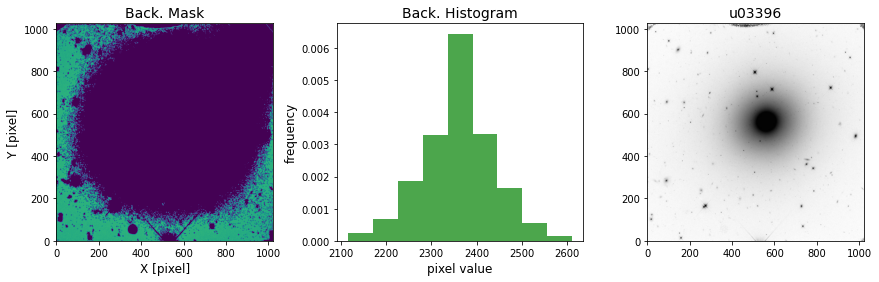

In [7]:
%matplotlib inline

_ = obj.plot_backsex()

Here, we do a crude calculations to generate an initial mask. The main objective is to mask out the large objects in the field.

- `minArea`: the minimum number of pixels in the masked regions
- `thresh`: the threshold factor that represents the signal to noise ratio of the detected segmented areas. Larger values would reduce the number of masked, because larger signal levels would satisfy the threshold condition.
- `smooth`: the smoothing factor. Larger values would enlarge the masked regions, because the signal is smeared across more neighborhood pixels.
- `mask=1`: the mask number. By default we start from `1`. However any other arbitrary integer value could be used.


*The segmentation and the associated generated mask are plotted.*
One may play with the input values to generate satisfactory initial masks.

In [8]:
widget = obj.slider_naive_sex()

widgets.HBox(widget)

fig. name:  Outputs_u03396/u03396_beb89749de93/u03396_initial_mask.png


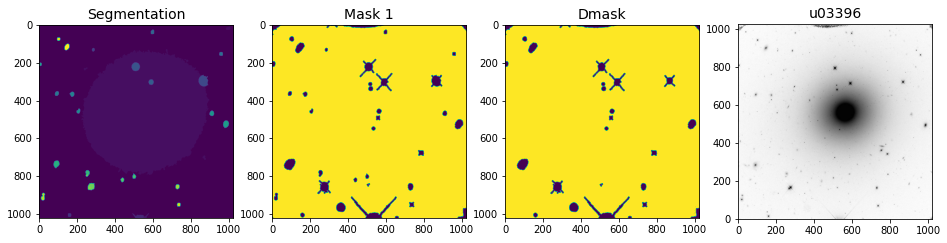

In [9]:
%matplotlib inline

_ = obj.plot_naivesex()

## Running Elliprof

Here, we run `elliprof` for the firt time. The initial mask that was generated above (e.g. mask=1) is utilized here and `model=0` is created. Usually, the Kron_radius factor is set to a value greater than 2 and smaller than 4.
The main goal is to generate very crude model.

- `r0`: Inner radius to fit
- `r1`: Outer radius to fit, i.e. `obj.outerR(c_kron)`, where `outerR` takes the Kron radius factor and converts it to number of pixels
- `c_kron`: Kron radius factor
- `sky`: sky value, which is roughly about 90% of the median of the values of the background pixels. *Note:* The sky level would be fine tuned later.
- `k`: A factor to determine the number of fitting radii, i.e. `nr=(r1-r0)/k`
- `options`: Any other that `elliprof` accepts. 

In [10]:
widget = obj.basic_elliprof_widget()

widgets.VBox(widget)

N_cross: 0
r0: 9
r1: 216
nr: 14
sky: 2127
fig. name:  Outputs_u03396/u03396_beb89749de93//u03396_basic_model.png


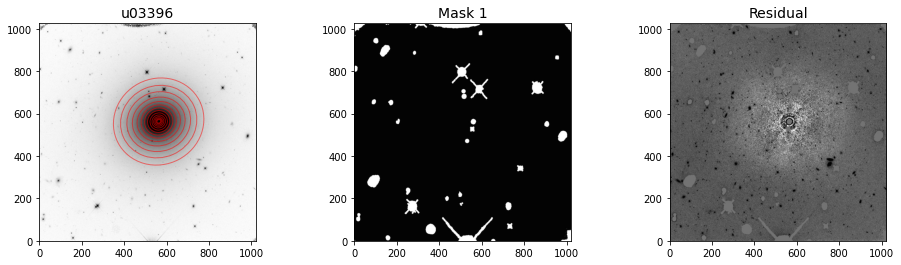

In [11]:
%matplotlib inline

_ = obj.basic_elliprof()

## Second round of elliprof

Here, we use the primary model that we generated in the previous cell to cover the masked regions.
Then we run SExtractor for additional mask. The residuals of model=0 is used to create another mask. The initial mask can be further augmented with the mask we generate here.

- `model=0`: initial profile model from the previous cell. The masked regions are replaced by this model
- `model_mask`: the model that is used to patch the masked regions

**Top**
- Left: Red ellipse displays the galaxy border defined by Kron radius

In [12]:
s1, s2 = obj.second_elliprof_widget()

box1 = widgets.VBox(s1)
box2 = widgets.VBox(s2)

widgets.HBox([box1,box2])


<IPython.core.display.Javascript object>


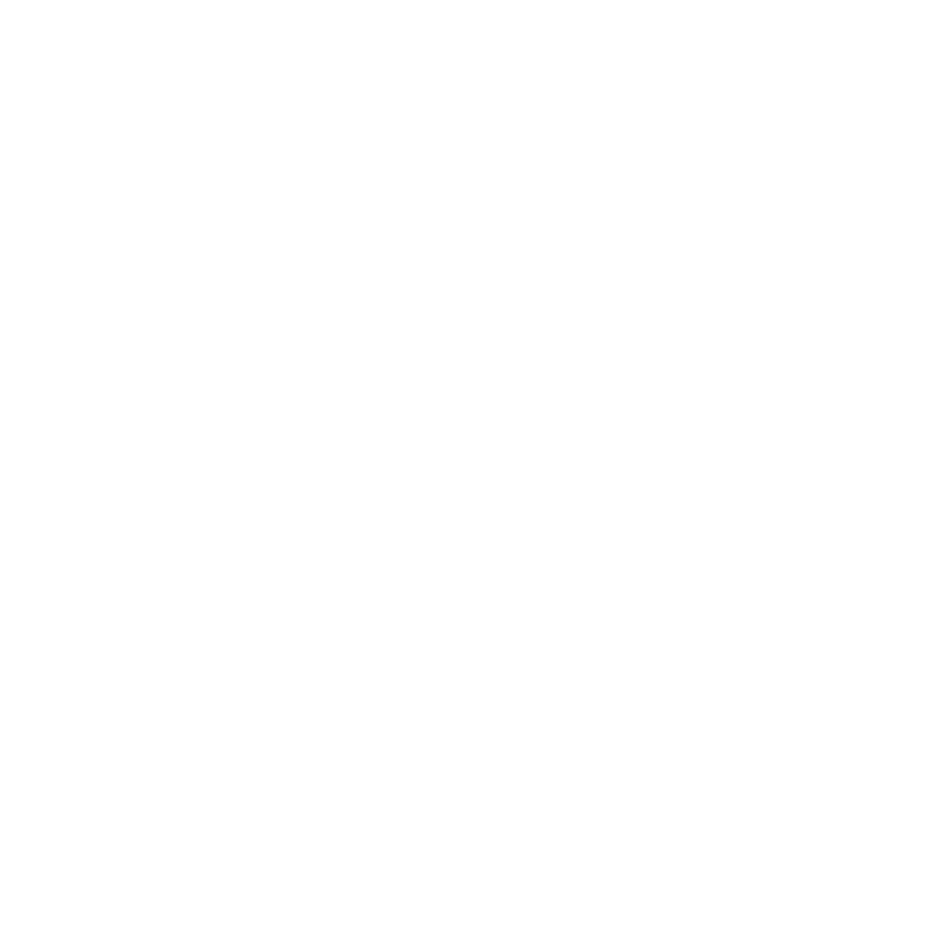

fig. name:  Outputs_u03396/u03396_beb89749de93//u03396_initial_model.png


Checkbox(value=False, description='Combine Mask')

In [13]:
%matplotlib notebook

_ = obj.second_elliprof()

checkbox = widgets.Checkbox(description='Combine Mask', value = False)
checkbox

## Mask augmentation

If we are happy with the additional mask we found above, we add these two masks and update the primary mask.
After updating the mask (`mask=1`), the previous cell can be iteratively executed with updating the mask multiple time until we are satisfied.

In [14]:
# combining mask1 and mask2 ----> mask1
if checkbox.value==True:
    obj.addMasks(maskList=[1,2], mask=1)

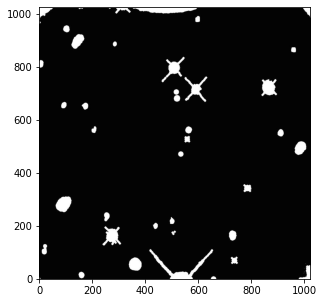

In [15]:
%matplotlib inline

plt.figure(figsize=(5,5))
plt.subplot(111)
ax = plt.gca()
obj.tv_mask(mask=1, ax=ax)

## Updating the background level

Here, we update the background factor, and regenerate the `elliprof` model until the median of the residual value of the background pixels is roughly zero. 

In [16]:
## test

option = obj.params["second_elliprof"]["option"]
c_kron = obj.params["second_elliprof"]["c_kron"]
k = obj.params["second_elliprof"]["k_ellipse"]

r0         = obj.params["second_elliprof"]["r0"] 
r1         = obj.outerR(c_kron)      
nr         = int(np.round((r1-r0)/k))
initial_sky_factor = obj.params["second_elliprof"]["sky_factor"]

# model #: the elliprof model id
optimized_sky_factor = obj.optimize_sky_factor(initial_sky_factor, r0, r1, nr, options=option, model=999)   

print("Optimized sky factor: ", "%.3f"%optimized_sky_factor)


Optimized sky factor:  0.961


In [17]:
if False:
    
    i = 1

    print("i, r0, r1, nr, n_cross, initial_sky_factor, final_sky_factor")

    while i<=10:

        c_kron = obj.params["second_elliprof"]["c_kron"] 
        option = obj.params["second_elliprof"]["option"] 

        r0 = np.random.randint(8,15)
        r1 = np.random.randint(obj.outerR(c_kron*0.9) , obj.outerR(c_kron*2))
        k = np.random.randint(8,15)
        nr = int(np.round(r1/k))
        sf = np.random.uniform(0.75,0.95)

        if i==1:
            model_mask=0
        else:
            model_mask = 1000-i+1

        sky_factor = obj.optimize_sky_factor(sf, r0, r1, nr, options=options, model_mask=model_mask,
                                         model=1000-i, verbose=False)


        if sky_factor!=0:

            ## how many ellipses cross each other
            n_cross = Xellipses(obj.list_ellipses(model=1000-i))

            if n_cross<4:
                print(i, r0, r1, nr, n_cross, '%.3f'%sf, '%.3f'%sky_factor)
                i+=1

        


In [18]:
sky_factor = optimized_sky_factor

## Plotting the light profile

So far, we found the optimum **sky factor** and the `initial mask`.
`r0` and `r1` has been chosen by user iteratively to get reasonable results.

Now, we visualize the light profile of galaxy and the residual image for the final check.

In the following plot we have
- **Left:** The light profile. Each point show the surface brightness on an ellipse. The horizontal axis is scaled to accommodate the `r^1/4` form. Open black circles represent the region used to find the red dotted line in a least square process. This linear fit is extrapolated towards larger radii to examine the behavior of the outer region. If a galaxy follows a pure `r^1/4`, all outer point must fall on the fitted line.

- **Right:** The residual image, which is generated by subtracting the primary model from the galaxy image. Red concentric ellipse are the ellipses. Yellow circles represent the region used for the linear fit in the left panel.

No. of crossing ellipses: 3
fig. name:  Outputs_u03396/u03396_beb89749de93/u03396_light_profile.png
profile table name:  Outputs_u03396/u03396_beb89749de93/u03396_light_profile.csv
   Rmaj      x0      y0        I0   alpha  ellip   I(3x)  A(3x)   I(4x)  \
0   9.0  590.75  566.95   89363.2    3.37  0.465  0.0037  69.72  0.0022   
1  12.9  573.01  565.79  204205.2   15.98  0.476  0.0366  26.89  0.0295   
2  17.8  571.37  560.13  183431.0  152.52  0.530  0.1717  92.58  0.0457   
3  24.2  562.83  562.55  131910.0  112.39  0.072  0.0030   5.87  0.0024   
4  32.0  562.82  562.53   81606.4  115.92  0.054  0.0007  81.22  0.0013   

   A(4x)  slope  
0  74.20  -2.00  
1   5.79  -2.00  
2  47.58  -0.62  
3  37.32  -1.32  
4  17.41  -1.88  


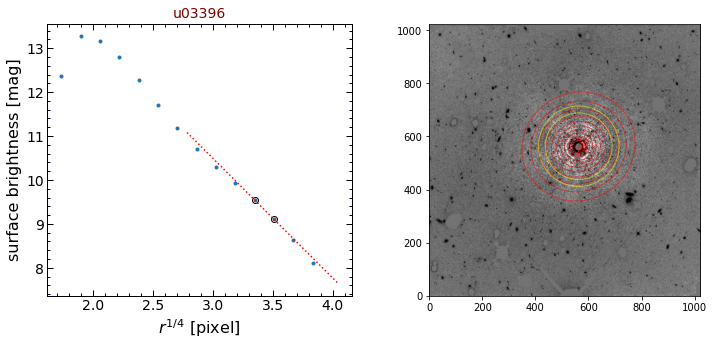

In [19]:
sky = int(sky_factor*obj.sky_med)

_ = obj.plot_profile(sky_factor, r0, r1, nr, options="", mask=1, model_mask=0)

## Visualizing the background histogram

In the following cell, the distribution of the residual values of the background pixels is plotted.
In the case of having a good model and sky value, the median/mean values of the residuals should be close to zero.

**Note:** Sometimes, very bright objects must be masked out manually to makes sure that there no contamination from such objects, otherwise the background must have been over-estimated.

Back Median: 4.68
Back Mean: 5.12
Back Stdev: 76.95
fig. name:  Outputs_u03396/u03396_beb89749de93//u03396_updated_back.png
New potential sky factor: 0.963


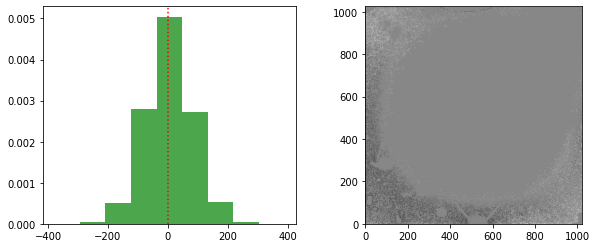

In [20]:
resid_name = obj.objRoot+"resid.000"
back_mask = obj.objRoot+"back_mask.fits"

imarray, header = imOpen(resid_name)
mskarray, header = imOpen(back_mask)

masked_image = imarray*mskarray

fits.writeto('./tmp.fits', np.float32(masked_image), overwrite=True)

## plot_2darray(imarray)
# tv('./tmp.fits', options='log')


a = masked_image
a = a[(a!=0)]
std = np.std(a)
mean = np.mean(a)

a = a[((a>mean-3.*std)&(a<mean+3.*std))]

median = np.median(a)
mean = np.mean(a)
std = np.std(a)

print("Back Median: %.2f"%median)
print("Back Mean: %.2f"%mean)
print("Back Stdev: %.2f"%std)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.hist(a, bins=np.linspace(mean-5*std, mean+5*std, 10), density=True, color='g', alpha=0.7)
tv('./tmp.fits', ax=ax2, options="")

ax1.axvline(x=0, color='r', linestyle=':')

new_factor = median/obj.sky_med + sky_factor


pngName = obj.objRoot+'/'+obj.name+'_updated_back.png'
plt.savefig(pngName)
print("fig. name: ", pngName)

print("New potential sky factor:", "%.3f"%new_factor)

## Saving the model

Here, we store all metadata and other information on disk to be used in other steps.

In [21]:


now = datetime.now()
model_uuid = str(uuid.uuid1())

objDict = {}

objDict["index"] = 'value'
objDict["uuid"] = model_uuid
objDict["User"] = os.getlogin().capitalize()
objDict["Time"] = now
objDict["Name"] = obj.name
objDict["X_pixels"] = obj.x_max
objDict["Y_pixels"] = obj.y_max
objDict["R_max"] = obj.r_max
objDict["X0"] = obj.x0
objDict["Y0"] = obj.y0
objDict["a"] = "%.3f"%obj.a
objDict["b"] = "%.3f"%obj.b
objDict["sky_med"] = "%.3f"%median
objDict["sky_avg"] = "%.3f"%mean
objDict["sky_std"] = "%.3f"%std
objDict["r0"] = r0
objDict["r1"] = r1
objDict["nr"] = nr
objDict["k"] = k
objDict["c_kron"] = c_kron
objDict["options"] = options
objDict["sky_factor"] = "%.2f"%sky_factor
objDict["sky"] = sky
objDict["initial_sky_med"] = "%.3f"%obj.sky_med
objDict["initial_sky_avg"] = "%.3f"%obj.sky_ave
objDict["initial_sky_std"] = "%.3f"%obj.sky_std

objDict["obj_root"] = obj.objRoot

objDict["resid_name"] = obj.objRoot+"resid.000"
objDict["model_name"] = obj.objRoot+"model.000"
objDict["back_mask"] = obj.objRoot+"back_mask.fits"
objDict["ellipseFile"] = root+'elliprof'+suffix

#######################################################################

df = pd.DataFrame.from_dict(objDict, orient='index', columns=['value'])
df['description'] = ''

#######################################################################
df.at["index", "description"] =  'description'
df.at["uuid", "description"] =  'Unique Identifier Code'
df.at["Name", "description"] =  'Object Name'
df.at["User", "description"] =  'User Name'
df.at["Time", "description"] =  'Modification Time'
df.at["X_pixels", "description"] =  'X-dimension of image [pixel]'
df.at["Y_pixels", "description"] =  'Y-dimension of image [pixel]'
df.at["R_max", "description"] =  'maximum horizontal/vertical distance from center to the image border [pixel]'
df.at["X0", "description"] =  'Object Center X0 [pixel]'
df.at["Y0", "description"] =  'Object Center Y0 [pixel]'
df.at["a", "description"] =  'semi-major axis [pixel]'
df.at["b", "description"] =  'semi-minor axis [pixel]'
df.at["sky_med", "description"] =  'median sky background after model subtraction'
df.at["sky_avg", "description"] =  'mean sky background after model subtraction'
df.at["sky_std", "description"] =  '1-sigma standard deviation of the sky background after model subtraction'
df.at["r0", "description"] =  'elliprof: inner fit radius'
df.at["r1", "description"] =  'elliprof: outer fit radius'
df.at["nr", "description"] =  'elliprof: number of fitted radii '
df.at["k", "description"] =  'nr=[r1/k]'
df.at["c_kron", "description"] =  'Kron radius factor'
df.at["options", "description"] =  'elliprof: options'
df.at["sky_factor", "description"] =  'sky factor'
df.at["sky", "description"] =  'sky level = sky_factor*initial_sky_median'
df.at["initial_sky_med", "description"] =  'initial sky median'
df.at["initial_sky_avg", "description"] =  'initial sky mean'
df.at["initial_sky_std", "description"] =  'initial sky standard deviation'

df.at["obj_root", "description"] =  'name of the outputs folder'

df.at["resid_name", "description"] =  'residual image [fits]'
df.at["model_name", "description"] =   'model image [fits]'
df.at["back_mask", "description"] =   'background mask [fits]'
df.at["ellipseFile", "description"] =   'ellipse file [text]'

#######################################################################

df = df.reset_index()
logFile = obj.objRoot+obj.name+"_model_log.csv"

from os.path import exists

if not exists(logFile):
    xcmd("echo '###### uuid:'"+model_uuid+"  > "+logFile+".temp", verbose=False)  # header
    np.savetxt(logFile, df.values, fmt='%20s , %40s , %80s')
    xcmd("cat "+logFile+" >> "+logFile+".temp", verbose=False)
    xcmd("mv "+logFile+".temp "+logFile, verbose=False)
else:   
    xcmd("echo '###### uuid:'"+model_uuid+"  > "+logFile+".temp~", verbose=False)  # header
    
    np.savetxt(logFile+".temp", df.values, fmt='%20s , %40s , %80s')
    xcmd("echo   >> "+logFile+".temp", verbose=False)
    
    xcmd("cat "+logFile+".temp"+" >> "+logFile+".temp~", verbose=False)
    xcmd("cat "+logFile+" >> "+logFile+".temp~", verbose=False)
    
    xcmd("mv "+logFile+".temp~ "+logFile, verbose=False)
    xcmd("rm "+logFile+".temp", verbose=False)
    
print("Log File: ", logFile)

df

NameError: name 'options' is not defined